In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     |████████████████████████████████| 195.4 MB 1.2 kB/s eta 0:00:014  |█                               | 5.6 MB 551 kB/s eta 0:05:45     |█▊                              | 10.4 MB 989 kB/s eta 0:03:07     |██                              | 11.7 MB 367 kB/s eta 0:08:20     |██▉                             | 17.3 MB 705 kB/s eta 0:04:13     |███▊                            | 22.7 MB 2.8 MB/s eta 0:01:02     |████▏                           | 25.2 MB 850 kB/s eta 0:03:21     |██████▋                         | 40.1 MB 1.9 MB/s eta 0:01:21     |████████▎                       | 50.2 MB 3.3 MB/s eta 0:00:45     |████████▊                       | 53.0 MB 834 kB/s eta 0:02:51     |█████████                       | 55.6 MB 822 kB/s eta 0:02:50 MB 822 kB/s eta 0:02:47��████▎                     | 62.6 MB 651 kB/s eta 0:03:24kB/s eta 0:02:54     |██████████████▍                 | 88.1 MB 745 kB/s eta 0:02:24     |███████████████▏         

In [1]:
# import torch first to remove error
import torch
from torch.utils.data import TensorDataset, Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import train, evaluate
import os
import shutil
import posixpath
import time

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline


In [2]:
# MOUNTPATH = '/mount'
MOUNTPATH = '../'
DATAPATH = MOUNTPATH + '/data' 
MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
def get_waveform_path(patientid, recordid):
    return WAVEFPATH + f'/{patientid[0:3]}/{patientid}/{recordid}'
CHANNEL_NAMES = ['HR','RESP','PULSE','etco2', 'SpO2', 'CVP','AWRR', 'NBP Mean',  'NBP Dias',   'NBP Sys']
OUTPUTPATH = MOUNTPATH + '/model' 

In [3]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import shutil
import os
from pyspark.sql.window import Window
import operator
import pyspark.sql.functions as F
import pandas as pd
from pyspark.pandas.frame import DataFrame
import os
import sys
import numpy as np
import warnings
import pyspark.pandas as ps

spark = SparkSession.builder.appName('app').getOrCreate()
sc = spark.sparkContext

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


23/04/07 01:18:12 WARN Utils: Your hostname, Michaels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.118 instead (on interface en0)
23/04/07 01:18:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/07 01:18:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
subject_id = 44083
# read this using datetime.datetime
cur_time = '2112-05-04-19-50'
# extract date from string
from datetime import datetime

date_str = '2112-05-04-19-50'
format_str = '%Y-%m-%d-%H-%M'

# Use format string '%Y-%m-%d-%H-%M' to create a datetime.datetime object
dt = datetime.strptime(date_str, format_str)

# Convert datetime.datetime to numpy.datetime64
waveform_date = np.datetime64(dt)

In [5]:
# Get patient age
patients_df = ps.read_csv(f'{MIMICPATH}/PATIENTS.csv.gz', usecols = ['SUBJECT_ID','DOB'])
bday = patients_df.query("SUBJECT_ID==44083")['DOB']
birthday_date = bday.values[0]

time_diff = np.timedelta64(waveform_date - birthday_date, 's')
age = time_diff.astype('float') / (3600 * 24 * 365.25)

# EXTRACT
# Calculate 

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/generic.py:647: UserWarning: We recommend using `Series.to_numpy()` instead.
  warnings.warn("We recommend using `{}.to_numpy()` instead.".format(type(self).__name__))
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/sql/pandas/conv

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_3216/2405870663.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p044083-2112-05-04-19-50n',
 'n_sig': 7,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 164919,
 'base_time': datetime.time(19, 50, 40),
 'base_date': datetime.date(2112, 5, 4),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR',
  'RESP',
  'PULSE',
  'SpO2',
  'NBP Mean',
  'NBP Dias',
  'NBP Sys'],
 'p_signal': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat',
  '3314767n.dat'],
 'fmt': ['16', '16', '16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None, None, None],
 'byte_

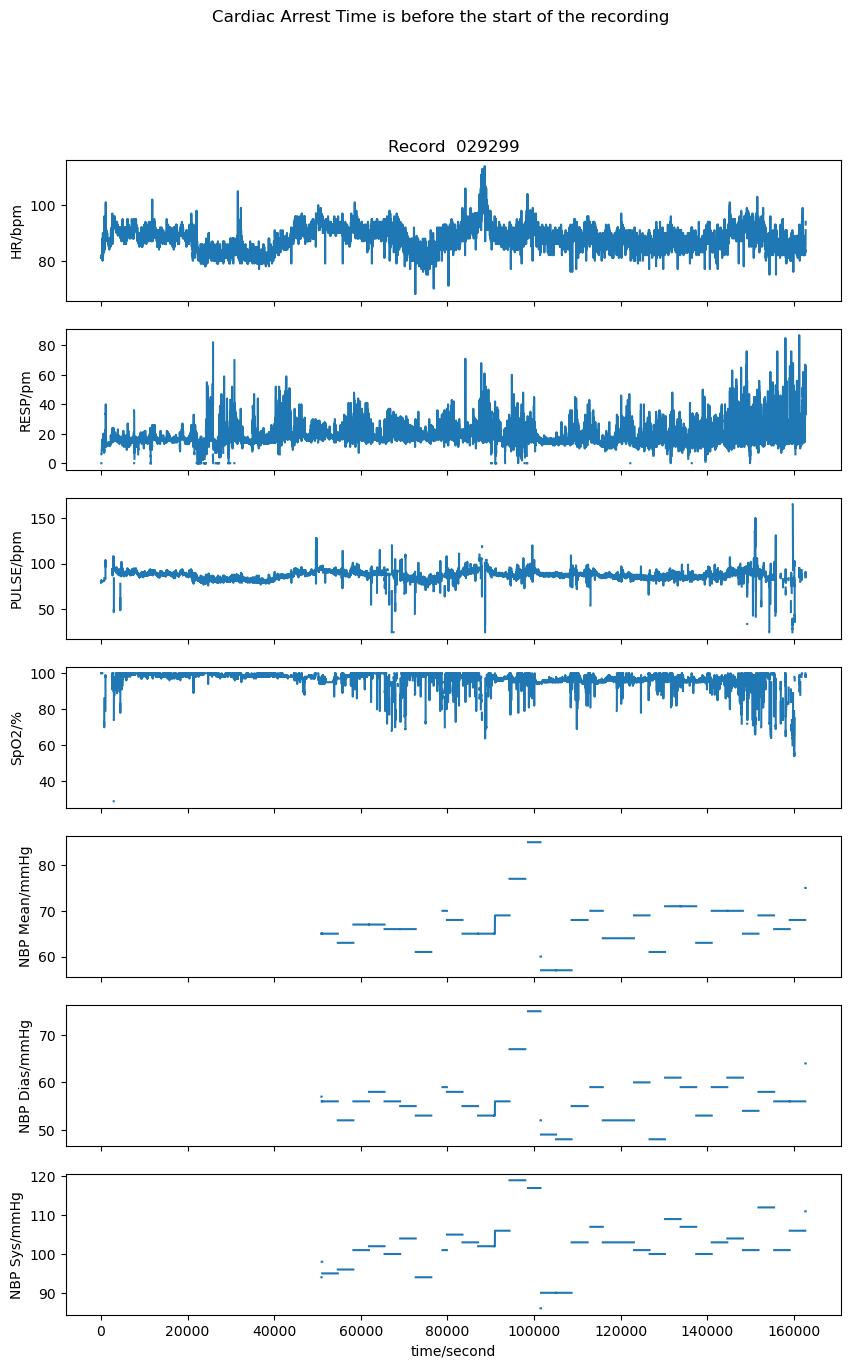

In [6]:
# This is a patient with cardiac arrest

patient_path = get_waveform_path('p044083', 'p044083-2112-05-04-19-50n')

# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=CHANNEL_NAMES)
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2112-05-04 04:38:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

In [7]:
record_df = record.to_dataframe()
record_df = record_df.interpolate(method='linear').fillna(0)

# We take ten minutes of data with 1 minute of sliding window
record_df = record_df.iloc[::5, :]

# Which means that each should have 120 records
record_arr = np.stack([record_df.iloc[i:i+int(600/5), :].values for i in range(0, len(record_df)-int(600/5), int(60/5))])
record_arr.shape

(2739, 120, 7)

In [8]:
record_arr = record_arr.reshape(2739, 7, 120)
record_arr

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  82.        ],
        [  0.        ,  81.        , 100.        , ...,   0.        ,
          82.        ,   6.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  81.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  81.        ,
          94.63741339,   0.        ],
        [  0.        ,   0.        ,  81.        , ...,  89.33718245,
           0.        ,   0.        ],
        [  0.        ,  82.        ,  10.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,  80.        , ...,   0.        ,
           0.        ,  82.        ],
        [  4.2       ,  81.        , 100.        , ...,   0.        ,
          81.        ,  11.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  80.        ],
        ...,


In [9]:
x = record_arr
record_df['y']=1
y = record_df['y'].astype(np.float32).values
y = np.random.randint(low=0, high=2, size=record_arr.shape[0]).squeeze()
age_arr = np.random.randint(30, 60, size=record_arr.shape[0]).squeeze() * 1.0
# y = torch.randint(2, size=(record_arr.shape[0],))
y.shape

(2739,)

In [10]:
age_arr.shape

(2739,)

In [11]:
x.shape

(2739, 7, 120)

In [12]:


def load_dataset(x,age_arr,y):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x).type(torch.FloatTensor)
	target = torch.from_numpy(y).type(torch.FloatTensor) # BCE with logit expects target to be float. CrossEntropy expects long
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float(), target.float())

	return dataset


In [13]:
dataset = load_dataset(x,age_arr,y)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
for i, (input, age, target) in enumerate(data_loader):
    print(input,age,target)

tensor([[[ 81.0000,  14.0000,  80.0000,  ...,   0.0000,   0.0000,  82.0000],
         [ 14.0000,  81.0000,  99.0000,  ...,   0.0000,  81.0000,  13.0000],
         [ 81.0000,  99.0000,   0.0000,  ...,  81.0000,  16.0000,  84.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,  82.0000,  99.0000,   0.0000],
         [  0.0000,   0.0000,  82.0000,  ...,  99.0000,   0.0000,   0.0000],
         [  0.0000,  82.0000,  14.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ 91.0000,  16.0000,  90.0000,  ...,   0.0000,   0.0000,  89.0000],
         [ 16.0000,  89.0000,  98.0000,  ...,   0.0000,  90.0000,  16.0000],
         [ 89.0000,  94.0000,   0.0000,  ...,  90.0000,  16.0000,  97.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,  90.3529,  96.9412,   0.0000],
         [  0.0000,   0.0000,  91.0000,  ...,  98.0000,   0.0000,   0.0000],
         [  0.0000,  94.0000,  13.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ 87.0000,  15.0000,  86.0000,  ...

In [19]:
class MyCNN(nn.Module):
	
	def __init__(self):
		# self.MAGIC_NUMBER = 16*41
		super(MyCNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=7, out_channels=4, kernel_size=5)
		self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
		# self.out = nn.Linear(in_features=567, out_features=1)

		self.dropout = nn.Dropout(0.5)
		self.lstm = nn.LSTM(input_size = 27, hidden_size=16, num_layers=2)
		self.out = nn.Linear(in_features=16, out_features=1, bias=True)

		self.age_fn = nn.Linear(in_features=1, out_features=1, bias=True)

	def forward(self, x, age):
		x = torch.tanh(self.conv1(x))
		x = self.pool(x)
		x = torch.tanh(self.conv2(x))
		x = self.pool(x)
		x = self.dropout(x)
		x = x.view(-1, 27)
		x,_ = self.lstm(x)
		x = torch.sigmoid(self.out(x))
		age_scale = self.age_fn(age.unsqueeze(1))
		x = (x*age_scale).squeeze()
		return x


# Lesson on why you need age.unsqueeze(1):
# The error is most likely caused by the fact that age is a tensor of shape (32,), which means it has 32 elements but is not a matrix. However, self.age_fn is a linear layer that expects a matrix as input. Specifically, the in_features parameter is set to 1, which means it expects a matrix of size (batch_size, 1).

# When you pass age to self.age_fn, it is implicitly expanded to a matrix of size (batch_size, 32) by adding a singleton dimension at the end (since age has size (32,)), which is not what you want. Instead, you should first unsqueeze the tensor along the second dimension (i.e., age.unsqueeze(1)) to get a matrix of size (batch_size, 1), and then pass it to self.age_fn.

In [15]:
age_arr.shape

(2739,)

In [21]:

# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
PATH_OUTPUT = "../model/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 100
BATCH_SIZE = 32
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN3.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

# train_dataset = load_seizure_dataset(PATH_TRAIN_FILE, MODEL_TYPE)
# valid_dataset = load_seizure_dataset(PATH_VALID_FILE, MODEL_TYPE)
# test_dataset = load_seizure_dataset(PATH_TEST_FILE, MODEL_TYPE)
train_dataset = load_dataset(x[0:1000],age_arr[0:1000], y[0:1000])
valid_dataset = load_dataset(x[1000:1500],age_arr[1000:1500], y[1000:1500])
test_dataset = load_dataset(x[1500:],age_arr[1500:], y[1500:])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(OUTPUTPATH, save_file), _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)

# class_names = ['Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen']
# plot_confusion_matrix(test_results, class_names)


Model Summary: 5240
Epoch: [0][0/32]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 7.1733 (7.1733)	Accuracy 50.000 (50.000)
Epoch: [0][10/32]	Time 0.003 (0.005)	Data 0.000 (0.001)	Loss 6.7242 (7.4052)	Accuracy 56.250 (51.989)
Epoch: [0][20/32]	Time 0.004 (0.005)	Data 0.000 (0.001)	Loss 9.0609 (7.1986)	Accuracy 43.750 (53.125)
Epoch: [0][30/32]	Time 0.004 (0.005)	Data 0.001 (0.001)	Loss 8.3024 (7.2777)	Accuracy 43.750 (51.915)
Test: [0/16]	Time 0.002 (0.002)	Loss 10.7950 (10.7950)	Accuracy 25.000 (25.000)
Test: [10/16]	Time 0.001 (0.001)	Loss 6.3438 (7.1766)	Accuracy 56.250 (51.136)
Epoch: [1][0/32]	Time 0.006 (0.006)	Data 0.001 (0.001)	Loss 6.9617 (6.9617)	Accuracy 53.125 (53.125)
Epoch: [1][10/32]	Time 0.005 (0.006)	Data 0.001 (0.001)	Loss 5.7849 (7.2872)	Accuracy 62.500 (51.705)
Epoch: [1][20/32]	Time 0.004 (0.005)	Data 0.000 (0.001)	Loss 8.5100 (7.0961)	Accuracy 43.750 (52.083)
Epoch: [1][30/32]	Time 0.004 (0.005)	Data 0.001 (0.001)	Loss 6.5556 (7.0185)	Accuracy 59.375 (52.319)
Test: [

In [67]:
model = torch.load(OUTPUTPATH+'/MyCNN2.pth')
test_dataset = load_dataset(x[1500:],y[1500:])
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1600, shuffle=False, num_workers=NUM_WORKERS)
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
evaluate(model, device, test_loader, criterion, print_freq=10)

TypeError: load_dataset() missing 1 required positional argument: 'y'